In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ma7amedhossam","key":"db543c0683c681d4d90de1c06a62516d"}'}

In [88]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [89]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [90]:
!unzip digit-recognizer.zip -d mnist_data

Archive:  digit-recognizer.zip
replace mnist_data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [91]:
train_df = pd.read_csv('mnist_data/train.csv')

print(train_df.shape)

(42000, 785)


In [92]:
X = train_df.drop('label', axis=1).values/255.0
t= train_df['label'].values

train_size = 0.6 * len(X)
val_size = 0.2 * len(X)
test_size = 0.2 * len(X)

X_train = X[:int(train_size)]
t_train = t[:int(train_size)]

X_val = X[int(train_size):int(train_size+val_size)]
t_val = t[int(train_size):int(train_size+val_size)]

X_test = X[int(train_size+val_size):]
t_test = t[int(train_size+val_size):]


## Converting into tensors

In [93]:
X_train = torch.tensor(X_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
t_val = torch.tensor(t_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.long)

## Dataloader

In [94]:
train_loader = DataLoader(TensorDataset(X_train, t_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, t_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, t_test), batch_size=64, shuffle=False)

## Creation of Neural Network

In [95]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,h1_size,h2_size,h3_size,out_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size,h1_size)
        self.l2 = nn.Linear(h1_size,h2_size)
        self.l3 = nn.Linear(h2_size,h3_size)
        self.l4 = nn.Linear(h3_size,out_size)
        self.relu = nn.ReLU()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    def forward(self, x):
        out = self.flatten(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        return out

### Initialzing an instance

In [96]:
input_size = 784
h1_size = 256
h2_size = 128
h3_size = 64
out_size = 10
nn_model = NeuralNetwork(input_size,h1_size,h2_size,h3_size,out_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

/tmp/ipython-input-827111595.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

### Loss Function

In [97]:
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

### Training and validating the model

In [98]:
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
  nn_model.train()
  train_loss = 0
  correct_preds = 0
  total_preds = 0
  for X_batch, t_batch in train_loader:
    X_batch = X_batch.to(device)
    t_batch = t_batch.to(device)

    optimizer.zero_grad()
    y = nn_model(X_batch)
    loss = criteration(y,t_batch)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, y_pred = torch.max(y, 1)
    correct_preds += (y_pred == t_batch).sum().item()
    total_preds += t_batch.size(0)
  avg_epoch_train_loss = train_loss / len(train_loader)
  train_losses.append(avg_epoch_train_loss)
  train_acc = correct_preds / total_preds * 100
  train_accuracies.append(train_acc)


  nn_model.eval()
  correct_pred = 0
  total_pred = 0
  val_loss = 0
  for X_batch, t_batch in val_loader:
    X_batch = X_batch.to(device)
    t_batch = t_batch.to(device)
    y_val = nn_model(X_batch)
    loss = criteration(y_val,t_batch)
    val_loss += loss.item()
    _, y_pred = torch.max(y_val, 1)
    correct_pred += (y_pred == t_batch).sum().item()
    total_pred += t_batch.size(0)
  avg_epoch_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_epoch_val_loss)
  val_accuracy = correct_pred / total_pred * 100
  val_accuracies.append(val_accuracy)
  print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')
  train_acc_mean = np.array(train_accuracies)
  val_acc_mean = np.array(val_accuracies)
  train_acc_std = np.std(train_accuracies, axis=0)
  val_acc_std = np.std(val_accuracies, axis=0)
  loss_diff = np.diff(train_losses)


Epoch 1/20, Train Loss: 1.1294, Val Loss: 0.5168
Epoch 2/20, Train Loss: 0.4192, Val Loss: 0.3635
Epoch 3/20, Train Loss: 0.3304, Val Loss: 0.3108
Epoch 4/20, Train Loss: 0.2860, Val Loss: 0.2770
Epoch 5/20, Train Loss: 0.2565, Val Loss: 0.2575
Epoch 6/20, Train Loss: 0.2335, Val Loss: 0.2397
Epoch 7/20, Train Loss: 0.2152, Val Loss: 0.2256
Epoch 8/20, Train Loss: 0.2001, Val Loss: 0.2118
Epoch 9/20, Train Loss: 0.1859, Val Loss: 0.2005
Epoch 10/20, Train Loss: 0.1735, Val Loss: 0.1969
Epoch 11/20, Train Loss: 0.1625, Val Loss: 0.1844
Epoch 12/20, Train Loss: 0.1527, Val Loss: 0.1813
Epoch 13/20, Train Loss: 0.1440, Val Loss: 0.1694
Epoch 14/20, Train Loss: 0.1356, Val Loss: 0.1654
Epoch 15/20, Train Loss: 0.1284, Val Loss: 0.1645
Epoch 16/20, Train Loss: 0.1214, Val Loss: 0.1608
Epoch 17/20, Train Loss: 0.1152, Val Loss: 0.1500
Epoch 18/20, Train Loss: 0.1094, Val Loss: 0.1485
Epoch 19/20, Train Loss: 0.1036, Val Loss: 0.1438
Epoch 20/20, Train Loss: 0.0987, Val Loss: 0.1428


### Plotting training vs validation errors

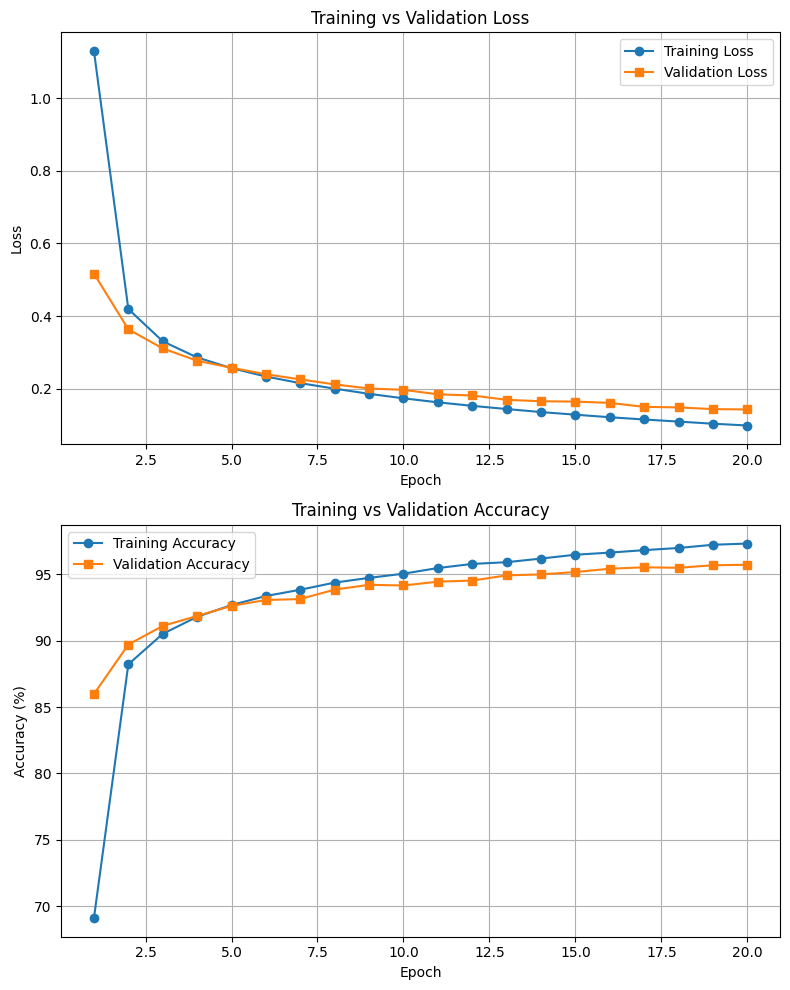

In [99]:
plt.figure(figsize=(8, 10))

# --- Plot 1: Training vs Validation Loss ---
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Training vs Validation Accuracy ---
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

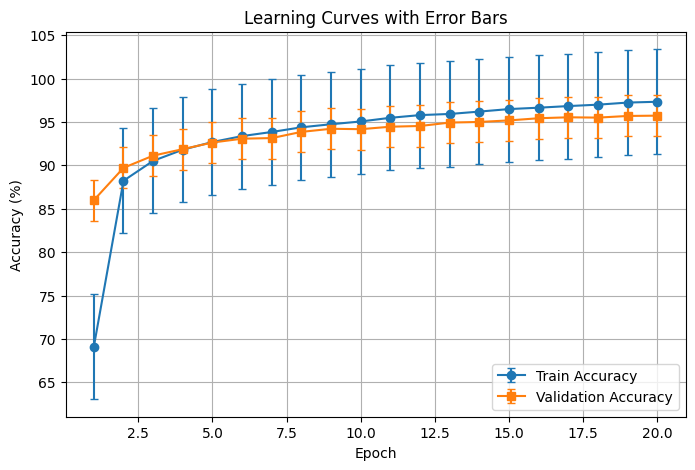

In [100]:
plt.figure(figsize=(8, 5))
plt.errorbar(range(1, epochs + 1), train_acc_mean, yerr=train_acc_std, fmt='-o', capsize=3, label='Train Accuracy')
plt.errorbar(range(1, epochs + 1), val_acc_mean, yerr=val_acc_std, fmt='-s', capsize=3, label='Validation Accuracy')
plt.title('Learning Curves with Error Bars')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

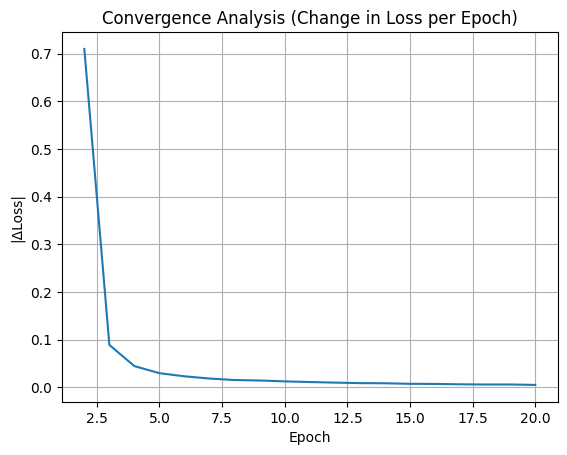

In [103]:
plt.plot(range(2, epochs + 1), np.abs(loss_diff))
plt.title('Convergence Analysis (Change in Loss per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('|ΔLoss|')
plt.grid(True)
plt.show()